In [ ]:
import pandas as pd
import numpy as np
import random
import torch
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)


In [ ]:
import os

IS_ON_COLAB = bool(os.getenv("COLAB_RELEASE_TAG"))

if IS_ON_COLAB:
    !pip install transformers==4.28.0
    !pip install tokenizers datasets sentencepiece huggingface_hub[cli] accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from datasets import load_dataset
from datasets import DatasetDict
from datasets import Dataset
from transformers import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from transformers import AutoTokenizer, TrainingArguments, Trainer ,AutoConfig, AutoModel, BatchEncoding

from sklearn.metrics import f1_score, accuracy_score, classification_report, make_scorer, hamming_loss, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier # didnot use this since doing with MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer # not required since I already one-hot encoding while preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AlbertForSequenceClassification,
    XLNetForSequenceClassification,
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments, AdamW , AutoModelForSequenceClassification
)

from hyperopt import fmin, tpe, hp
from functools import partial
from torch.nn import BCEWithLogitsLoss
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [ ]:
clinical_trial = load_dataset("opentargets/clinical_trial_reason_to_stop")
clinical_trial

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 3747
    })
})

In [ ]:
clinical_trial_traintest = clinical_trial["train"].train_test_split(test_size=0.1)
clinical_trial_testeval = clinical_trial_traintest["test"].train_test_split(test_size=0.5)
clinical_trial_traintest

DatasetDict({
    train: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 3372
    })
    test: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 375
    })
})

In [ ]:
clinical_trial_testeval

DatasetDict({
    train: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 187
    })
    test: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 188
    })
})

In [ ]:
final_dataset = DatasetDict({
    'train': clinical_trial_traintest['train'],
    'test': clinical_trial_testeval['test'],
    'valid': clinical_trial_testeval['train']})
final_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 3372
    })
    test: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success'],
        num_rows: 188
    })
    valid: Dataset({
        features: ['text', 'label_descriptions', 'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficie

In [ ]:
from collections import Counter

train_labels_lists = final_dataset["train"]["label_descriptions"]

if not train_labels_lists:
    print("No labels found in the train dataset. Please check the dataset structure.")
else:
    # Flatten the lists of labels into a single list
    train_labels_flat = [label for labels_per_example in train_labels_lists for label in labels_per_example]

    # Count the occurrences of each label
    label_counts = Counter(train_labels_flat)

    # Print the label counts
    for label, count in label_counts.items():
        print(f"{label}: {count}")


Insufficient_Enrollment: 968
Study_Design: 283
Covid19: 159
Logistics_Resources: 272
Insufficient_Data: 35
Study_Staff_Moved: 146
Negative: 335
Safety_Sideeffects: 195
Business_Administrative: 722
Invalid_Reason: 218
Regulatory: 99
Another_Study: 179
No_Context: 73
Endpoint_Met: 44
Interim_Analysis: 22
Ethical_Reason: 16
Success: 18


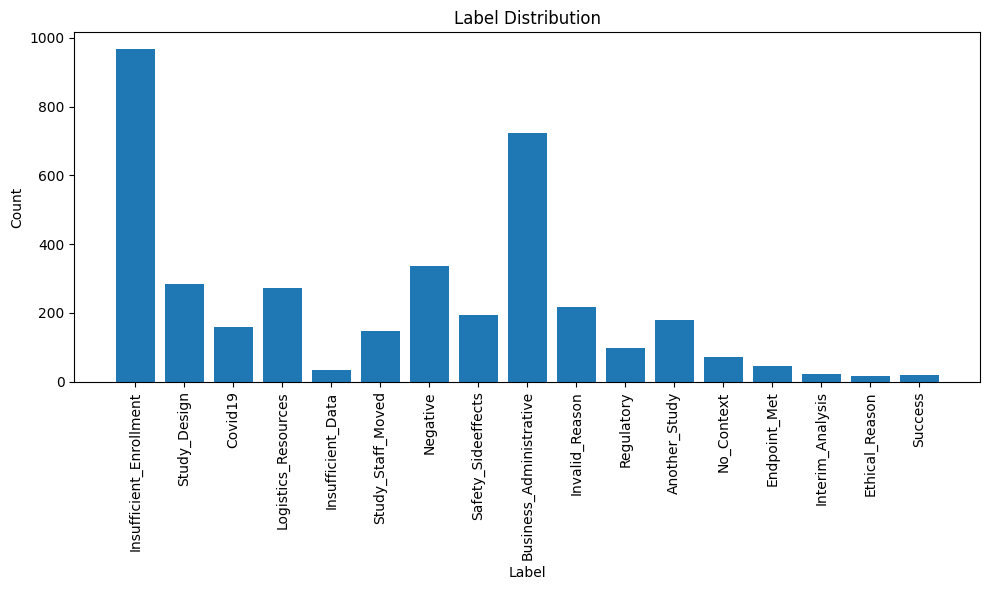

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter


train_labels_lists = final_dataset["train"]["label_descriptions"]

if not train_labels_lists:
    print("No labels found in the train dataset. Please check the dataset structure.")
else:
    # Flatten the lists of labels into a single list
    train_labels_flat = [label for labels_per_example in train_labels_lists for label in labels_per_example]

    # Count the occurrences of each label
    label_counts = Counter(train_labels_flat)

    # Separate label names and their corresponding counts
    label_names, counts = zip(*label_counts.items())

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(label_names, counts)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title("Label Distribution")
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
train_dataset = final_dataset['train'].map(lambda example: {"labels": example["label_descriptions"]})
valid_dataset = final_dataset['valid'].map(lambda example: {"labels": example["label_descriptions"]})
test_dataset = final_dataset['test'].map(lambda example: {"labels": example["label_descriptions"]})

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

In [ ]:

# Load the tokenizer
#tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

label_columns = [
    'Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met',
    'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment',
    'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative',
    'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design',
    'Study_Staff_Moved', 'Success'
]

# Create a mapping from class names to numerical indices
class_to_index = {label: index for index, label in enumerate(label_columns)}



num_classes = len(label_columns)

# Extract class names (column names)
class_names = label_columns

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

def preprocess_labels(example):
    labels = example["labels"]
    print("Before:", example["labels"]) #(while re-running comment it out)

    # Convert labels to binary vector
    label_indices = [class_to_index[label] for label in labels]
    labels_tensor = torch.zeros(num_classes, dtype=torch.float32)
    labels_tensor[label_indices] = 1

    example["labels"] = labels_tensor
    print("After:", example["labels"])
    return example



id2label = {i: label for i, label in enumerate(class_names)}


# # Preprocess the labels using one-hot encoding
# train_dataset = train_dataset.map(preprocess_labels)
# val_dataset = valid_dataset.map(preprocess_labels)
# test_dataset = test_dataset.map(preprocess_labels)



Number of classes: 17
Class names: ['Another_Study', 'Business_Administrative', 'Covid19', 'Endpoint_Met', 'Ethical_Reason', 'Insufficient_Data', 'Insufficient_Enrollment', 'Interim_Analysis', 'Invalid_Reason', 'Logistics_Resources', 'Negative', 'No_Context', 'Regulatory', 'Safety_Sideeffects', 'Study_Design', 'Study_Staff_Moved', 'Success']


In [ ]:

# Define the is_numeric_labels function since it is a loop so if the onehot encoding in done it will show error for the next classifier

def is_numeric_labels(dataset):
    labels = dataset["labels"]
    return isinstance(labels[0], torch.Tensor)

# Load the tokenizers
tokenizers = {
    "xlnet-base-cased": AutoTokenizer.from_pretrained("xlnet-base-cased"),
    "textattack/albert-base-v2-imdb": AutoTokenizer.from_pretrained("textattack/albert-base-v2-imdb"),
    "bert-base-uncased": AutoTokenizer.from_pretrained("bert-base-uncased"),
    "cardiffnlp/twitter-roberta-base-emotion": AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion"),
    "distilbert-base-uncased": AutoTokenizer.from_pretrained("distilbert-base-uncased")
}

# Models and their corresponding class names
models = {
    "xlnet-base-cased": XLNetForSequenceClassification,
    "textattack/albert-base-v2-imdb": AlbertForSequenceClassification,
    "bert-base-uncased": BertForSequenceClassification,
    "cardiffnlp/twitter-roberta-base-emotion": RobertaForSequenceClassification,
    "distilbert-base-uncased": DistilBertForSequenceClassification
}

# Hyperparameter search space
# Hyperparameter grid for the current model
hyperparameter_grid = {
    "num_train_epochs": [7, 10],
    "learning_rate": [1e-5, 5e-5, 2e-04],
    "per_device_train_batch_size": [32],
}

def compute_metrics(pred):
    labels = torch.tensor(pred.label_ids, dtype=torch.float)  # Convert labels to a PyTorch tensor
    preds = torch.tensor(pred.predictions, dtype=torch.float)  # Convert predictions to a PyTorch tensor
    loss_fct = torch.nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for multi-label classification
    loss = loss_fct(preds, labels) # Ensuring labels are in float format
    preds = torch.sigmoid(preds) > 0.3  # Apply threshold for binary classification
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    hamming = hamming_loss(labels, preds)
    acc = accuracy_score(labels, preds)
    #return {"loss": loss.item(), "accuracy": acc, "f1": f1, "hamming_loss": hamming}


# Calculate precision and recall
    precision = precision_score(labels, preds, average="weighted", zero_division=0)
    recall = recall_score(labels, preds, average="weighted", zero_division=0)

    return {"loss": loss.item(), "accuracy": acc, "f1": f1, "hamming_loss": hamming, "precision": precision, "recall": recall}

# Loop through each model
best_model_hyperparameters = {}  # To store the best hyperparameters for each model
best_model_metrics = {}  # To store the best validation metrics for each model

for model_name, model_class in models.items():
    print(f"Training {model_name} model...")

    # Initialize variables to keep track of the best hyperparameters and metrics for this model
    best_hyperparameters = None
    best_metrics = None

    # Load model's configuration and update it with id2label mapping
    model_config = AutoConfig.from_pretrained(model_name)
    model_config.update({"id2label": id2label})

    # Load model using the updated configuration
    model = model_class.from_pretrained(model_name, num_labels=num_classes, problem_type="multi_label_classification", ignore_mismatched_sizes=True)
    tokenizer = tokenizers[model_name]

    # Tokenize and preprocess the datasets
    train_dataset = train_dataset.map(lambda examples: tokenizer(examples["text"], padding=True, truncation=True), batched=True, batch_size=len(train_dataset))
    val_dataset = valid_dataset.map(lambda examples: tokenizer(examples["text"], padding=True, truncation=True), batched=True, batch_size=len(valid_dataset))
    test_dataset = test_dataset.map(lambda examples: tokenizer(examples["text"], padding=True, truncation=True), batched=True, batch_size=len(test_dataset))

    if not is_numeric_labels(train_dataset):
        train_dataset = train_dataset.map(preprocess_labels)
    if not is_numeric_labels(val_dataset):
        val_dataset = val_dataset.map(preprocess_labels)
    if not is_numeric_labels(test_dataset):
        test_dataset = test_dataset.map(preprocess_labels)

    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    # Loop through hyperparameter combinations
    for epoch in hyperparameter_grid["num_train_epochs"]:
        for lr in hyperparameter_grid["learning_rate"]:
          for batch in hyperparameter_grid["per_device_train_batch_size"]:
            training_args = TrainingArguments(
                seed=random_seed,
                output_dir=f"{model_name}-results",  # Store results in separate directories
                num_train_epochs=epoch,
                per_device_train_batch_size=batch,
                per_device_eval_batch_size=batch,
                evaluation_strategy="epoch",
                logging_strategy="steps",
                optim = "adamw_torch",
                logging_steps=10,
                learning_rate=lr,
                weight_decay=0.01,
                warmup_steps=500,
                save_strategy="epoch",
                load_best_model_at_end=True,
                save_total_limit=2,
                report_to="tensorboard"
            )

            # Instantiate the Trainer
            trainer = Trainer(
                model=model.to(device),
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=compute_metrics,
            )

            # Train the model
            trainer.train()

            print(f"Model trained with num_train_epochs={epoch} , learning_rate={lr} and per_device_train_batch_size={batch}.")

            # Evaluate the model on the validation dataset
            eval_results = trainer.evaluate()

            # Extract the validation metrics
            val_f1 = eval_results['eval_f1']
            val_accuracy = eval_results['eval_accuracy']
            val_hamming_loss = eval_results['eval_hamming_loss']
            val_loss = eval_results['eval_loss']
            val_precision = eval_results['eval_precision']
            val_recall = eval_results['eval_recall']

            # Print or log the validation metrics for this hyperparameter combination
            
            print(f"Model: {model_name}, num_train_epochs={epoch}, learning_rate={lr}, per_device_train_batch_size={batch} - Validation F1: {val_f1:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Hamming Loss: {val_hamming_loss:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")

            # Keep track of the best hyperparameters based on validation performance
            if best_metrics is None or val_f1 > best_metrics["f1"]:
                best_hyperparameters = {"num_train_epochs": epoch, "learning_rate": lr, "per_device_train_batch_size":batch}
                best_metrics = {"f1": val_f1, "accuracy": val_accuracy, "hammloss": val_hamming_loss, "loss": val_loss, "precision": val_precision, "recall": val_recall}

    # Store the best hyperparameters and metrics for this model
    best_model_hyperparameters[model_name] = best_hyperparameters
    best_model_metrics[model_name] = best_metrics

    # Print a completion message for this model's hyperparameter tuning
    print(f"{model_name} model training and hyperparameter tuning completed.")


# Print the best hyperparameters and metrics for each model
for model_name in models.keys():
    best_hp = best_model_hyperparameters[model_name]
    best_metrics = best_model_metrics[model_name]
    print(f"Best hyperparameters for {model_name}: {best_hp}")
    print(f"Best validation metrics for {model_name}: {best_metrics}")


Training xlnet-base-cased model...


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
Before: ['Another_Study', 'Negative']
After: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Another_Study']
After: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Business_Administrative']
After: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Business_Administrative']
After: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Business_Administrative']
After: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Study_Design', 'Another_Study']
After: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Before: ['Covid19']
After: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before:

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Before: ['Business_Administrative', 'Insufficient_Enrollment']
After: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Negative']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Regulatory']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Safety_Sideeffects']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Before: ['Interim_Analysis']
After: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Business_Administrative', 'Another_Study']
After: tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Invalid_Reason']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Logistics_Resources']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Study_Design', 'No_Context']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])
Before: ['Study_Design']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0.

Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.412500,0.150991,0.319079,0.016043,0.205233,0.134623,0.473684,0.535500,349.185000,11.204000
2,0.225600,0.066059,0.214115,0.005348,0.009114,0.095694,0.004785,0.533400,350.592000,11.249000
3,0.210900,0.063227,0.206572,0.042781,0.067549,0.287081,0.038278,0.547500,341.534000,10.958000
4,0.199000,0.057251,0.182108,0.331551,0.337056,0.339648,0.334928,0.567800,329.322000,10.566000
5,0.161500,0.045612,0.149836,0.497326,0.479897,0.536008,0.511962,0.538300,347.398000,11.146000
6,0.136200,0.037748,0.132647,0.566845,0.587846,0.616105,0.602871,0.571300,327.331000,10.503000
7,0.121900,0.037748,0.127531,0.577540,0.590419,0.597159,0.612440,0.593300,315.204000,10.113000


Model trained with num_train_epochs=7 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=7, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.5904, Validation Accuracy: 0.5775, Validation Hamming Loss: 0.0377, Validation Precision: 0.5972, Validation Recall: 0.6124


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.112000,0.036489,0.120948,0.598930,0.612360,0.652310,0.631579,0.582700,320.919000,10.297000
2,0.108100,0.036804,0.112950,0.620321,0.670711,0.685341,0.698565,0.581500,321.605000,10.319000
3,0.091600,0.030513,0.102858,0.663102,0.718745,0.744683,0.727273,0.574800,325.356000,10.439000
4,0.093100,0.033973,0.096635,0.636364,0.716220,0.716727,0.722488,0.578900,323.027000,10.364000
5,0.075400,0.036175,0.106658,0.620321,0.706612,0.701656,0.722488,0.551000,339.387000,10.889000
6,0.047700,0.031142,0.094575,0.689840,0.734196,0.723331,0.755981,0.574800,325.350000,10.439000
7,0.036100,0.031456,0.095676,0.679144,0.728706,0.715435,0.755981,0.582800,320.878000,10.296000


Model trained with num_train_epochs=7 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=7, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7342, Validation Accuracy: 0.6898, Validation Hamming Loss: 0.0311, Validation Precision: 0.7233, Validation Recall: 0.7560


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.043700,0.031142,0.099633,0.679144,0.722012,0.725348,0.732057,0.574200,325.644000,10.448000
2,0.056100,0.033344,0.106765,0.652406,0.715334,0.723238,0.732057,0.574700,325.366000,10.440000
3,0.062200,0.039006,0.129131,0.631016,0.685528,0.689895,0.693780,0.573200,326.223000,10.467000
4,0.078800,0.040579,0.122914,0.598930,0.690203,0.709584,0.693780,0.565400,330.764000,10.613000
5,0.080900,0.040893,0.139490,0.625668,0.659200,0.681566,0.665072,0.565100,330.897000,10.617000
6,0.071400,0.029884,0.104452,0.689840,0.756227,0.772425,0.765550,0.567600,329.431000,10.570000
7,0.040600,0.030198,0.100126,0.700535,0.747366,0.731679,0.775120,0.583000,320.743000,10.291000


Model trained with num_train_epochs=7 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=7, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7220, Validation Accuracy: 0.6791, Validation Hamming Loss: 0.0311, Validation Precision: 0.7253, Validation Recall: 0.7321


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.029700,0.032400,0.094940,0.673797,0.727709,0.713234,0.755981,0.585700,319.281000,10.244000
2,0.034700,0.033658,0.095430,0.663102,0.724162,0.708576,0.755981,0.571500,327.228000,10.499000
3,0.028900,0.031771,0.094632,0.663102,0.737966,0.717481,0.770335,0.582400,321.073000,10.302000
4,0.031500,0.033973,0.099603,0.657754,0.722402,0.703475,0.760766,0.589100,317.410000,10.184000
5,0.026000,0.032715,0.098825,0.668449,0.740295,0.731619,0.770335,0.536100,348.804000,11.192000
6,0.023200,0.031142,0.098468,0.673797,0.743681,0.742746,0.765550,0.572500,326.632000,10.480000
7,0.024000,0.032400,0.104010,0.663102,0.737703,0.731517,0.765550,0.579000,322.998000,10.364000
8,0.026500,0.033658,0.107938,0.647059,0.727069,0.727260,0.751196,0.587600,318.218000,10.210000
9,0.020100,0.033344,0.106627,0.652406,0.719203,0.727772,0.732057,0.581400,321.656000,10.320000
10,0.021200,0.032400,0.106450,0.663102,0.726468,0.736651,0.736842,0.533600,350.435000,11.244000


Model trained with num_train_epochs=10 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=10, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.7380, Validation Accuracy: 0.6631, Validation Hamming Loss: 0.0318, Validation Precision: 0.7175, Validation Recall: 0.7703


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.023500,0.035546,0.099978,0.652406,0.709124,0.702085,0.736842,0.579500,322.674000,10.353000
2,0.026500,0.033344,0.103546,0.647059,0.732033,0.719291,0.765550,0.580000,322.435000,10.345000
3,0.026600,0.033973,0.105815,0.647059,0.725783,0.720787,0.760766,0.582600,320.997000,10.299000
4,0.035600,0.037119,0.116708,0.614973,0.699178,0.708467,0.708134,0.571100,327.414000,10.505000
5,0.027700,0.032715,0.105174,0.663102,0.751023,0.734229,0.779904,0.549500,340.318000,10.919000
6,0.027300,0.032400,0.113156,0.679144,0.736951,0.746944,0.760766,0.573600,325.983000,10.459000
7,0.020000,0.034288,0.121567,0.657754,0.730721,0.728736,0.755981,0.579200,322.835000,10.358000
8,0.017800,0.030198,0.112973,0.668449,0.757416,0.745938,0.789474,0.575700,324.843000,10.423000
9,0.011300,0.029884,0.113714,0.679144,0.748020,0.749900,0.765550,0.574600,325.426000,10.441000
10,0.010600,0.031456,0.111230,0.668449,0.743317,0.735743,0.770335,0.548600,340.867000,10.937000


Model trained with num_train_epochs=10 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=10, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7091, Validation Accuracy: 0.6524, Validation Hamming Loss: 0.0355, Validation Precision: 0.7021, Validation Recall: 0.7368


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.023300,0.034288,0.111216,0.663102,0.709605,0.707534,0.736842,0.579000,322.946000,10.362000
2,0.052800,0.040893,0.122508,0.593583,0.679457,0.697002,0.693780,0.574500,325.489000,10.444000
3,0.054500,0.039635,0.126491,0.614973,0.670974,0.679716,0.669856,0.584900,319.736000,10.259000
4,0.079100,0.039950,0.117941,0.625668,0.684009,0.688511,0.698565,0.575100,325.142000,10.432000
5,0.078400,0.039950,0.129459,0.625668,0.658099,0.654280,0.688995,0.540500,345.989000,11.101000
6,0.064900,0.038062,0.115582,0.625668,0.710044,0.709852,0.741627,0.574100,325.749000,10.452000
7,0.054300,0.036489,0.126607,0.657754,0.696642,0.696533,0.727273,0.578700,323.163000,10.369000
8,0.050800,0.036804,0.126931,0.657754,0.707581,0.699674,0.741627,0.575300,325.029000,10.429000
9,0.037100,0.033973,0.115347,0.673797,0.735730,0.715014,0.770335,0.588100,317.969000,10.202000
10,0.028300,0.036175,0.120027,0.647059,0.728121,0.717096,0.755981,0.544500,343.455000,11.020000


Model trained with num_train_epochs=10 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: xlnet-base-cased, num_train_epochs=10, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7096, Validation Accuracy: 0.6631, Validation Hamming Loss: 0.0343, Validation Precision: 0.7075, Validation Recall: 0.7368
xlnet-base-cased model training and hyperparameter tuning completed.
Training textattack/albert-base-v2-imdb model...


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at textattack/albert-base-v2-imdb and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Before: ['Business_Administrative', 'Insufficient_Enrollment']
After: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Negative']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Regulatory']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Safety_Sideeffects']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0

Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.586700,0.893992,0.552845,0.000000,0.251124,0.155242,0.952153,0.487400,383.695000,12.311000
2,0.261500,0.081472,0.248340,0.240642,0.193174,0.170593,0.306220,0.478900,390.439000,12.527000
3,0.205900,0.058509,0.205272,0.256684,0.307742,0.296109,0.325359,0.477800,391.371000,12.557000
4,0.174700,0.051903,0.174302,0.433155,0.401877,0.376811,0.444976,0.484800,385.712000,12.376000
5,0.156200,0.043095,0.155198,0.508021,0.499910,0.534643,0.521531,0.477200,391.872000,12.573000
6,0.134400,0.038062,0.144092,0.545455,0.563038,0.619347,0.559809,0.477500,391.599000,12.565000
7,0.123100,0.039006,0.140058,0.545455,0.558624,0.611441,0.564593,0.480600,389.107000,12.485000


Model trained with num_train_epochs=7 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=7, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.5586, Validation Accuracy: 0.5455, Validation Hamming Loss: 0.0390, Validation Precision: 0.6114, Validation Recall: 0.5646


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.111400,0.036804,0.133553,0.556150,0.594115,0.664522,0.593301,0.487900,383.243000,12.297000
2,0.111900,0.039321,0.126340,0.566845,0.618344,0.629915,0.631579,0.477500,391.641000,12.566000
3,0.096100,0.033029,0.117025,0.620321,0.655041,0.691823,0.636364,0.482100,387.915000,12.446000
4,0.093500,0.035546,0.108191,0.652406,0.692246,0.722455,0.717703,0.479300,390.189000,12.519000
5,0.079600,0.033973,0.102669,0.668449,0.707929,0.720571,0.717703,0.472300,395.962000,12.705000
6,0.067800,0.034917,0.103624,0.647059,0.705447,0.722954,0.717703,0.481700,388.232000,12.457000
7,0.043900,0.027996,0.089777,0.700535,0.756696,0.757368,0.775120,0.484100,386.310000,12.395000


Model trained with num_train_epochs=7 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=7, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7567, Validation Accuracy: 0.7005, Validation Hamming Loss: 0.0280, Validation Precision: 0.7574, Validation Recall: 0.7751


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.046500,0.033658,0.100231,0.652406,0.714269,0.710800,0.736842,0.479900,389.690000,12.503000
2,0.076200,0.034288,0.099675,0.636364,0.715516,0.726279,0.717703,0.476200,392.657000,12.599000
3,0.089000,0.040893,0.118532,0.556150,0.650108,0.636372,0.674641,0.478800,390.589000,12.532000
4,0.094200,0.037433,0.115472,0.620321,0.666831,0.735244,0.631579,0.477500,391.606000,12.565000
5,0.092900,0.039006,0.113231,0.625668,0.667627,0.692572,0.660287,0.474000,394.522000,12.658000
6,0.072700,0.039006,0.097060,0.636364,0.704655,0.692250,0.736842,0.479000,390.428000,12.527000
7,0.047900,0.028625,0.089458,0.684492,0.755996,0.738429,0.779904,0.477300,391.821000,12.572000


Model trained with num_train_epochs=7 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=7, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7560, Validation Accuracy: 0.6845, Validation Hamming Loss: 0.0286, Validation Precision: 0.7384, Validation Recall: 0.7799


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.036200,0.029254,0.090074,0.684492,0.757242,0.741011,0.779904,0.485000,385.601000,12.372000
2,0.042200,0.029569,0.090061,0.700535,0.752488,0.738135,0.775120,0.486600,384.338000,12.332000
3,0.032600,0.030198,0.091297,0.689840,0.748928,0.733446,0.770335,0.483200,387.034000,12.418000
4,0.033100,0.030513,0.095598,0.689840,0.749419,0.743723,0.765550,0.482300,387.754000,12.441000
5,0.029400,0.032715,0.097983,0.663102,0.738306,0.737645,0.751196,0.475400,393.390000,12.622000
6,0.025200,0.030827,0.098985,0.673797,0.753009,0.749988,0.765550,0.475100,393.627000,12.630000
7,0.024800,0.031142,0.097960,0.684492,0.749000,0.737832,0.770335,0.477900,391.268000,12.554000
8,0.021600,0.032715,0.100799,0.663102,0.746770,0.740982,0.765550,0.482200,387.839000,12.444000
9,0.017400,0.032715,0.101473,0.663102,0.742872,0.735668,0.760766,0.477400,391.722000,12.569000
10,0.018900,0.033029,0.101388,0.657754,0.744974,0.738592,0.765550,0.490400,381.319000,12.235000


Model trained with num_train_epochs=10 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=10, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.7525, Validation Accuracy: 0.7005, Validation Hamming Loss: 0.0296, Validation Precision: 0.7381, Validation Recall: 0.7751


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.032000,0.031771,0.092693,0.673797,0.740183,0.726787,0.760766,0.477200,391.840000,12.572000
2,0.036800,0.032715,0.098026,0.663102,0.735144,0.725951,0.755981,0.479800,389.765000,12.506000
3,0.029100,0.033029,0.105956,0.668449,0.731195,0.739306,0.741627,0.476500,392.441000,12.592000
4,0.032100,0.033658,0.111417,0.657754,0.748413,0.750389,0.765550,0.486400,384.465000,12.336000
5,0.030300,0.039635,0.123088,0.614973,0.719014,0.725157,0.736842,0.479500,389.987000,12.513000
6,0.026200,0.037433,0.117077,0.641711,0.719459,0.723132,0.732057,0.474900,393.739000,12.633000
7,0.016900,0.037119,0.116619,0.647059,0.728950,0.722202,0.755981,0.472900,395.398000,12.687000
8,0.015200,0.037119,0.111823,0.631016,0.736629,0.719658,0.765550,0.480800,388.953000,12.480000
9,0.010400,0.033344,0.114102,0.657754,0.749083,0.745846,0.770335,0.478800,390.560000,12.531000
10,0.011400,0.033973,0.113198,0.668449,0.747722,0.740373,0.770335,0.485600,385.104000,12.356000


Model trained with num_train_epochs=10 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=10, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7402, Validation Accuracy: 0.6738, Validation Hamming Loss: 0.0318, Validation Precision: 0.7268, Validation Recall: 0.7608


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.032300,0.031771,0.097798,0.673797,0.736409,0.718459,0.765550,0.500200,373.858000,11.995000
2,0.052700,0.032715,0.098667,0.631016,0.741044,0.744310,0.751196,0.478700,390.634000,12.534000
3,0.050000,0.037433,0.107979,0.657754,0.724217,0.719935,0.741627,0.477000,392.058000,12.579000
4,0.076700,0.035860,0.117075,0.614973,0.703874,0.727939,0.712919,0.480700,389.030000,12.482000
5,0.075100,0.042781,0.117786,0.572193,0.672443,0.678064,0.698565,0.473100,395.226000,12.681000
6,0.065500,0.044039,0.123996,0.593583,0.668961,0.706339,0.650718,0.487200,383.835000,12.316000
7,0.044500,0.039321,0.129025,0.614973,0.690498,0.703383,0.698565,0.486200,384.602000,12.340000
8,0.046000,0.038377,0.107586,0.609626,0.738170,0.735073,0.765550,0.482000,387.939000,12.447000
9,0.031300,0.038377,0.122754,0.636364,0.704818,0.693602,0.727273,0.478500,390.799000,12.539000
10,0.024300,0.037748,0.117967,0.641711,0.715803,0.706806,0.732057,0.482200,387.781000,12.442000


Model trained with num_train_epochs=10 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: textattack/albert-base-v2-imdb, num_train_epochs=10, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7364, Validation Accuracy: 0.6738, Validation Hamming Loss: 0.0318, Validation Precision: 0.7185, Validation Recall: 0.7656
textattack/albert-base-v2-imdb model training and hyperparameter tuning completed.
Training bert-base-uncased model...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Before: ['Business_Administrative', 'Insufficient_Enrollment']
After: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Negative']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Regulatory']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Safety_Sideeffects']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0

Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.621700,0.915068,0.583465,0.000000,0.251550,0.155295,0.971292,0.472600,395.647000,12.695000
2,0.370400,0.130230,0.344284,0.016043,0.209222,0.136575,0.478469,0.466600,400.801000,12.860000
3,0.271300,0.072979,0.255830,0.299465,0.228967,0.241201,0.330144,0.459600,406.836000,13.054000
4,0.229300,0.052847,0.220468,0.262032,0.270248,0.387976,0.272727,0.458000,408.296000,13.100000
5,0.207200,0.048128,0.195906,0.374332,0.363666,0.354603,0.373206,0.430300,434.603000,13.944000
6,0.185500,0.048757,0.181484,0.379679,0.362570,0.344896,0.382775,0.458000,408.288000,13.100000
7,0.176400,0.050330,0.177150,0.379679,0.355144,0.333019,0.382775,0.451900,413.850000,13.279000


Model trained with num_train_epochs=7 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=7, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.3551, Validation Accuracy: 0.3797, Validation Hamming Loss: 0.0503, Validation Precision: 0.3330, Validation Recall: 0.3828


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.159700,0.045926,0.163789,0.438503,0.428393,0.454027,0.444976,0.455300,410.691000,13.177000
2,0.142100,0.039006,0.137624,0.545455,0.529671,0.548850,0.555024,0.459500,406.926000,13.056000
3,0.114500,0.032715,0.114711,0.631016,0.679291,0.731085,0.688995,0.457400,408.838000,13.118000
4,0.099300,0.028940,0.095035,0.689840,0.754786,0.754371,0.770335,0.453100,412.716000,13.242000
5,0.074800,0.033344,0.105662,0.657754,0.713526,0.706648,0.727273,0.431700,433.220000,13.900000
6,0.056800,0.028311,0.095296,0.711230,0.745925,0.741173,0.755981,0.464600,402.480000,12.914000
7,0.042400,0.028625,0.090433,0.705882,0.745875,0.740862,0.755981,0.465700,401.566000,12.884000


Model trained with num_train_epochs=7 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=7, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7459, Validation Accuracy: 0.7059, Validation Hamming Loss: 0.0286, Validation Precision: 0.7409, Validation Recall: 0.7560


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.045600,0.029569,0.094756,0.684492,0.738047,0.731809,0.755981,0.457300,408.883000,13.119000
2,0.053200,0.033344,0.094418,0.652406,0.721147,0.699213,0.760766,0.475200,393.499000,12.626000
3,0.052800,0.033344,0.105449,0.641711,0.720509,0.715882,0.736842,0.461200,405.463000,13.010000
4,0.072400,0.032715,0.111570,0.647059,0.729191,0.734974,0.741627,0.458800,407.587000,13.078000
5,0.066000,0.034602,0.112717,0.641711,0.713522,0.715544,0.732057,0.421300,443.915000,14.243000
6,0.047800,0.029254,0.098878,0.695187,0.752331,0.748669,0.770335,0.458000,408.261000,13.099000
7,0.028200,0.028940,0.093439,0.695187,0.774338,0.767468,0.794258,0.454500,411.398000,13.200000


Model trained with num_train_epochs=7 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=7, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7743, Validation Accuracy: 0.6952, Validation Hamming Loss: 0.0289, Validation Precision: 0.7675, Validation Recall: 0.7943


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.021400,0.028940,0.092933,0.705882,0.773441,0.771902,0.789474,0.463000,403.860000,12.958000
2,0.021300,0.028311,0.092860,0.695187,0.778540,0.770396,0.799043,0.462000,404.752000,12.987000
3,0.018800,0.028311,0.092980,0.705882,0.778167,0.772505,0.794258,0.463400,403.550000,12.948000
4,0.020100,0.029254,0.094549,0.689840,0.777341,0.766120,0.799043,0.458100,408.244000,13.099000
5,0.015700,0.028625,0.093145,0.700535,0.774554,0.765752,0.794258,0.429100,435.747000,13.981000
6,0.014800,0.027367,0.094850,0.700535,0.788662,0.775279,0.813397,0.453300,412.496000,13.235000
7,0.016100,0.028311,0.097151,0.705882,0.780256,0.771600,0.799043,0.458000,408.291000,13.100000
8,0.013300,0.028311,0.097228,0.705882,0.780595,0.771049,0.799043,0.469800,398.055000,12.772000
9,0.013000,0.027367,0.098324,0.716578,0.781851,0.775189,0.799043,0.456100,409.962000,13.154000
10,0.012600,0.027682,0.098311,0.716578,0.779256,0.774330,0.794258,0.431700,433.161000,13.898000


Model trained with num_train_epochs=10 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=10, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.7785, Validation Accuracy: 0.6952, Validation Hamming Loss: 0.0283, Validation Precision: 0.7704, Validation Recall: 0.7990


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.017600,0.028625,0.094620,0.711230,0.775064,0.766692,0.794258,0.456100,409.977000,13.154000
2,0.018200,0.028940,0.097261,0.711230,0.768536,0.765354,0.789474,0.455500,410.573000,13.173000
3,0.016200,0.024536,0.096072,0.732620,0.801216,0.800236,0.813397,0.463600,403.369000,12.942000
4,0.018900,0.028311,0.099364,0.700535,0.770460,0.769557,0.789474,0.461100,405.565000,13.013000
5,0.011400,0.030827,0.104530,0.689840,0.762060,0.751822,0.789474,0.434200,430.633000,13.817000
6,0.011100,0.031771,0.109303,0.695187,0.765770,0.748020,0.799043,0.469200,398.557000,12.788000
7,0.010300,0.031456,0.120806,0.673797,0.752386,0.747253,0.779904,0.456100,410.007000,13.155000
8,0.007300,0.028311,0.117573,0.695187,0.766820,0.766780,0.784689,0.457400,408.816000,13.117000
9,0.007700,0.030198,0.121239,0.684492,0.758762,0.759768,0.779904,0.453100,412.685000,13.241000
10,0.008100,0.029254,0.120868,0.689840,0.761953,0.764950,0.779904,0.435800,429.058000,13.767000


Model trained with num_train_epochs=10 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=10, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7751, Validation Accuracy: 0.7112, Validation Hamming Loss: 0.0286, Validation Precision: 0.7667, Validation Recall: 0.7943


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.015600,0.029254,0.098507,0.700535,0.770465,0.764755,0.789474,0.462900,403.977000,12.962000
2,0.025600,0.038377,0.116308,0.614973,0.738521,0.737802,0.765550,0.470700,397.307000,12.748000
3,0.037700,0.036804,0.120926,0.636364,0.724541,0.707159,0.760766,0.466800,400.577000,12.853000
4,0.043300,0.035860,0.124026,0.647059,0.725157,0.757031,0.722488,0.456500,409.673000,13.145000
5,0.045300,0.039321,0.133114,0.614973,0.708253,0.721743,0.717703,0.428600,436.352000,14.001000
6,0.033200,0.035860,0.127465,0.652406,0.738182,0.753348,0.746411,0.466800,400.615000,12.854000
7,0.032000,0.035231,0.128478,0.641711,0.722081,0.704577,0.751196,0.450600,415.021000,13.316000
8,0.021800,0.030198,0.117770,0.657754,0.760253,0.761016,0.765550,0.464700,402.413000,12.912000
9,0.012000,0.031142,0.120217,0.679144,0.751949,0.748772,0.765550,0.458600,407.767000,13.083000
10,0.008800,0.031456,0.116874,0.663102,0.756916,0.747396,0.779904,0.429400,435.456000,13.972000


Model trained with num_train_epochs=10 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: bert-base-uncased, num_train_epochs=10, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7705, Validation Accuracy: 0.7005, Validation Hamming Loss: 0.0293, Validation Precision: 0.7648, Validation Recall: 0.7895
bert-base-uncased model training and hyperparameter tuning completed.
Training cardiffnlp/twitter-roberta-base-emotion model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Before: ['Business_Administrative', 'Insufficient_Enrollment']
After: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Negative']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Regulatory']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Safety_Sideeffects']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0

Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.513900,0.645486,0.448746,0.000000,0.252173,0.156923,0.880383,0.436800,428.136000,13.737000
2,0.288900,0.066688,0.264501,0.240642,0.180063,0.139590,0.253589,0.441000,424.058000,13.606000
3,0.237100,0.058194,0.224164,0.240642,0.214300,0.185553,0.253589,0.431800,433.114000,13.897000
4,0.204500,0.050645,0.193210,0.320856,0.329498,0.337598,0.330144,0.444200,420.985000,13.508000
5,0.180300,0.045297,0.168083,0.443850,0.432810,0.429629,0.444976,0.403900,463.023000,14.856000
6,0.156100,0.039635,0.151586,0.529412,0.530988,0.577301,0.545455,0.441100,423.939000,13.602000
7,0.143800,0.039006,0.145901,0.561497,0.564469,0.606922,0.583732,0.445800,419.513000,13.460000


Model trained with num_train_epochs=7 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=7, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.5645, Validation Accuracy: 0.5615, Validation Hamming Loss: 0.0390, Validation Precision: 0.6069, Validation Recall: 0.5837


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.129700,0.037433,0.133946,0.604278,0.586742,0.604538,0.607656,0.439500,425.482000,13.652000
2,0.116600,0.034917,0.116042,0.609626,0.661434,0.646801,0.693780,0.452500,413.264000,13.260000
3,0.095500,0.033973,0.103378,0.636364,0.696491,0.729418,0.703349,0.450400,415.176000,13.321000
4,0.080700,0.028940,0.094594,0.695187,0.752344,0.749610,0.765550,0.441500,423.528000,13.589000
5,0.063200,0.034602,0.099806,0.652406,0.720210,0.705947,0.746411,0.394600,473.873000,15.204000
6,0.049400,0.034917,0.098605,0.641711,0.712176,0.693026,0.746411,0.442800,422.327000,13.551000
7,0.042400,0.031456,0.089729,0.684492,0.736019,0.715973,0.765550,0.432300,432.566000,13.879000


Model trained with num_train_epochs=7 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=7, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7360, Validation Accuracy: 0.6845, Validation Hamming Loss: 0.0315, Validation Precision: 0.7160, Validation Recall: 0.7656


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.039500,0.030827,0.094307,0.679144,0.742202,0.753485,0.746411,0.441500,423.513000,13.589000
2,0.056300,0.039950,0.121739,0.620321,0.687280,0.722277,0.708134,0.450500,415.097000,13.319000
3,0.057200,0.033973,0.109696,0.679144,0.720124,0.718426,0.732057,0.442100,422.934000,13.570000
4,0.073000,0.036489,0.114251,0.663102,0.721014,0.730983,0.727273,0.450300,415.254000,13.324000
5,0.075300,0.037119,0.114529,0.641711,0.709195,0.738153,0.712919,0.409800,456.277000,14.640000
6,0.054000,0.030513,0.102682,0.695187,0.751308,0.758316,0.765550,0.438900,426.098000,13.672000
7,0.029200,0.029254,0.104002,0.700535,0.761143,0.761932,0.770335,0.444900,420.310000,13.486000


Model trained with num_train_epochs=7 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=7, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7422, Validation Accuracy: 0.6791, Validation Hamming Loss: 0.0308, Validation Precision: 0.7535, Validation Recall: 0.7464


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.031500,0.030198,0.091511,0.695187,0.759500,0.767390,0.770335,0.448200,417.217000,13.387000
2,0.037000,0.031142,0.090475,0.663102,0.764329,0.749916,0.794258,0.427100,437.818000,14.048000
3,0.031800,0.029254,0.089136,0.689840,0.779947,0.762160,0.813397,0.441800,423.295000,13.582000
4,0.032800,0.033973,0.094490,0.652406,0.756569,0.743233,0.784689,0.452700,413.094000,13.254000
5,0.024800,0.035231,0.098750,0.631016,0.744561,0.724832,0.789474,0.409100,457.156000,14.668000
6,0.028300,0.032400,0.092933,0.663102,0.757675,0.745217,0.789474,0.445800,419.511000,13.460000
7,0.024100,0.031142,0.094194,0.673797,0.770569,0.752102,0.803828,0.437700,427.246000,13.708000
8,0.026300,0.030513,0.094604,0.684492,0.770084,0.751270,0.803828,0.447500,417.858000,13.407000
9,0.018600,0.029884,0.092123,0.684492,0.773995,0.754420,0.803828,0.439600,425.372000,13.648000
10,0.023500,0.030827,0.093992,0.673797,0.767655,0.752141,0.794258,0.405100,461.636000,14.812000


Model trained with num_train_epochs=10 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=10, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.7799, Validation Accuracy: 0.6898, Validation Hamming Loss: 0.0293, Validation Precision: 0.7622, Validation Recall: 0.8134


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.027000,0.028311,0.087439,0.695187,0.785254,0.770978,0.818182,0.442900,422.198000,13.546000
2,0.030500,0.032715,0.098211,0.657754,0.751602,0.729879,0.794258,0.441900,423.157000,13.577000
3,0.028400,0.030198,0.095075,0.700535,0.766480,0.747205,0.799043,0.441100,423.963000,13.603000
4,0.033400,0.029884,0.097385,0.716578,0.764536,0.764939,0.775120,0.448800,416.663000,13.369000
5,0.032100,0.034917,0.109466,0.625668,0.735880,0.713522,0.775120,0.399100,468.570000,15.034000
6,0.025500,0.034602,0.117279,0.647059,0.725001,0.713833,0.760766,0.446400,418.881000,13.440000
7,0.022600,0.034917,0.117242,0.647059,0.746960,0.743345,0.779904,0.446000,419.255000,13.452000
8,0.019900,0.031142,0.106202,0.679144,0.749865,0.719002,0.789474,0.439500,425.488000,13.652000
9,0.009900,0.029569,0.104591,0.700535,0.759057,0.742641,0.784689,0.448700,416.767000,13.372000
10,0.012000,0.030513,0.107766,0.689840,0.756137,0.739569,0.784689,0.408000,458.332000,14.706000


Model trained with num_train_epochs=10 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=10, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7853, Validation Accuracy: 0.6952, Validation Hamming Loss: 0.0283, Validation Precision: 0.7710, Validation Recall: 0.8182


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.026300,0.032715,0.099836,0.657754,0.754789,0.740339,0.784689,0.444400,420.774000,13.501000
2,0.049800,0.037119,0.108575,0.636364,0.720056,0.721153,0.760766,0.449200,416.317000,13.358000
3,0.061200,0.037748,0.125473,0.609626,0.700168,0.695323,0.722488,0.447500,417.837000,13.407000
4,0.073200,0.034288,0.108777,0.652406,0.732752,0.739388,0.736842,0.445900,419.374000,13.456000
5,0.077100,0.030513,0.105198,0.705882,0.727811,0.720013,0.746411,0.403300,463.660000,14.877000
6,0.060100,0.032715,0.112618,0.695187,0.722173,0.714544,0.736842,0.438700,426.289000,13.678000
7,0.046200,0.034602,0.115063,0.679144,0.731306,0.726237,0.751196,0.439300,425.709000,13.659000
8,0.046400,0.033029,0.113525,0.679144,0.731761,0.723470,0.755981,0.443000,422.097000,13.543000
9,0.024700,0.027682,0.099861,0.721925,0.766940,0.752031,0.789474,0.436600,428.346000,13.744000
10,0.019800,0.030198,0.105442,0.695187,0.756784,0.746534,0.779904,0.402300,464.857000,14.915000


Model trained with num_train_epochs=10 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: cardiffnlp/twitter-roberta-base-emotion, num_train_epochs=10, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7548, Validation Accuracy: 0.6578, Validation Hamming Loss: 0.0327, Validation Precision: 0.7403, Validation Recall: 0.7847
cardiffnlp/twitter-roberta-base-emotion model training and hyperparameter tuning completed.
Training distilbert-base-uncased model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Map:   0%|          | 0/3372 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Map:   0%|          | 0/188 [00:00<?, ? examples/s]

Map:   0%|          | 0/187 [00:00<?, ? examples/s]

Before: ['Business_Administrative', 'Insufficient_Enrollment']
After: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Before: ['Negative']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
Before: ['Regulatory']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Before: ['Study_Staff_Moved']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
Before: ['Safety_Sideeffects']
After: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
Before: ['Insufficient_Enrollment']
After: tensor([0

Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.658800,0.934256,0.641008,0.000000,0.253632,0.156360,1.000000,0.238500,783.986000,25.155000
2,0.399000,0.201321,0.377449,0.000000,0.220848,0.139647,0.588517,0.236900,789.297000,25.325000
3,0.289100,0.101604,0.272513,0.133690,0.194379,0.130609,0.382775,0.237200,788.298000,25.293000
4,0.232300,0.055363,0.224269,0.192513,0.217251,0.236420,0.200957,0.239100,782.166000,25.096000
5,0.196900,0.051274,0.188239,0.390374,0.389482,0.390500,0.406699,0.230800,810.057000,25.991000
6,0.171600,0.046241,0.166924,0.486631,0.452952,0.422185,0.492823,0.238300,784.726000,25.178000
7,0.159700,0.045926,0.160843,0.502674,0.460096,0.420697,0.511962,0.237300,787.905000,25.280000


Model trained with num_train_epochs=7 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=7, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.4601, Validation Accuracy: 0.5027, Validation Hamming Loss: 0.0459, Validation Precision: 0.4207, Validation Recall: 0.5120


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.142400,0.045297,0.148560,0.524064,0.477473,0.459711,0.531100,0.244500,764.864000,24.541000
2,0.126000,0.034288,0.123740,0.614973,0.634739,0.655388,0.645933,0.240000,779.225000,25.002000
3,0.101900,0.037119,0.110283,0.631016,0.656313,0.662590,0.669856,0.240800,776.638000,24.919000
4,0.089900,0.036489,0.100206,0.625668,0.713870,0.695035,0.746411,0.242400,771.575000,24.756000
5,0.067800,0.036175,0.099105,0.641711,0.717478,0.714068,0.736842,0.234400,797.920000,25.602000
6,0.048600,0.031771,0.093756,0.668449,0.734713,0.724370,0.755981,0.237900,785.922000,25.217000
7,0.033000,0.028940,0.093237,0.679144,0.759285,0.747155,0.779904,0.235200,795.135000,25.512000


Model trained with num_train_epochs=7 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=7, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7593, Validation Accuracy: 0.6791, Validation Hamming Loss: 0.0289, Validation Precision: 0.7472, Validation Recall: 0.7799


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.033200,0.035231,0.100466,0.636364,0.717646,0.717000,0.736842,0.238000,785.867000,25.215000
2,0.042900,0.037119,0.115778,0.604278,0.709670,0.710861,0.736842,0.237300,787.971000,25.282000
3,0.044100,0.036489,0.121864,0.631016,0.714698,0.704134,0.746411,0.242300,771.928000,24.768000
4,0.059200,0.035860,0.129336,0.620321,0.705981,0.724282,0.717703,0.238700,783.250000,25.131000
5,0.048500,0.035860,0.121632,0.631016,0.718236,0.737014,0.717703,0.220700,847.487000,27.192000
6,0.036100,0.035546,0.112570,0.647059,0.718451,0.712006,0.741627,0.239200,781.741000,25.083000
7,0.014000,0.033658,0.109449,0.668449,0.738892,0.733540,0.760766,0.237300,788.085000,25.286000


Model trained with num_train_epochs=7 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=7, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7176, Validation Accuracy: 0.6364, Validation Hamming Loss: 0.0352, Validation Precision: 0.7170, Validation Recall: 0.7368


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.020900,0.032086,0.097687,0.663102,0.733716,0.726917,0.751196,0.254400,735.033000,23.584000
2,0.027700,0.032086,0.098234,0.663102,0.741648,0.731877,0.765550,0.233900,799.492000,25.652000
3,0.023700,0.031771,0.098485,0.663102,0.741153,0.720533,0.770335,0.237300,788.105000,25.287000
4,0.024900,0.032400,0.101630,0.673797,0.735546,0.714830,0.765550,0.242000,772.756000,24.794000
5,0.020000,0.031771,0.102013,0.663102,0.750311,0.745743,0.770335,0.219200,853.236000,27.377000
6,0.019200,0.033344,0.105300,0.636364,0.738808,0.734498,0.760766,0.238200,785.181000,25.193000
7,0.016700,0.031142,0.106141,0.657754,0.745796,0.736123,0.770335,0.251300,744.178000,23.877000
8,0.020500,0.031456,0.107813,0.657754,0.742543,0.731255,0.765550,0.234000,799.092000,25.639000
9,0.014600,0.031142,0.107329,0.657754,0.748636,0.756986,0.765550,0.232700,803.766000,25.789000
10,0.017300,0.032086,0.108120,0.657754,0.735359,0.719463,0.760766,0.235500,793.978000,25.475000


Model trained with num_train_epochs=10 , learning_rate=1e-05 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=10, learning_rate=1e-05, per_device_train_batch_size=32 - Validation F1: 0.7337, Validation Accuracy: 0.6631, Validation Hamming Loss: 0.0321, Validation Precision: 0.7269, Validation Recall: 0.7512


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.020400,0.033029,0.103590,0.652406,0.718975,0.710696,0.736842,0.235500,794.095000,25.479000
2,0.028200,0.032400,0.106230,0.647059,0.731408,0.730338,0.755981,0.250300,747.058000,23.970000
3,0.023600,0.030827,0.105609,0.652406,0.749685,0.744722,0.770335,0.237300,788.054000,25.285000
4,0.023100,0.039006,0.116729,0.609626,0.701617,0.703635,0.717703,0.237000,789.066000,25.318000
5,0.019100,0.037433,0.128838,0.593583,0.715775,0.707541,0.736842,0.217000,861.684000,27.648000
6,0.019100,0.034602,0.126118,0.663102,0.729491,0.725671,0.741627,0.241500,774.275000,24.843000
7,0.013100,0.036804,0.128745,0.604278,0.731716,0.715863,0.770335,0.242400,771.323000,24.748000
8,0.010500,0.037748,0.132179,0.614973,0.713448,0.682696,0.751196,0.236200,791.799000,25.405000
9,0.007800,0.032715,0.130170,0.652406,0.738785,0.740126,0.751196,0.239700,780.036000,25.028000
10,0.008100,0.033344,0.132751,0.663102,0.741161,0.744586,0.751196,0.236400,790.906000,25.377000


Model trained with num_train_epochs=10 , learning_rate=5e-05 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=10, learning_rate=5e-05, per_device_train_batch_size=32 - Validation F1: 0.7190, Validation Accuracy: 0.6524, Validation Hamming Loss: 0.0330, Validation Precision: 0.7107, Validation Recall: 0.7368


Epoch,Training Loss,Validation Loss,Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second,Steps Per Second
1,0.018000,0.036175,0.118722,0.614973,0.711206,0.719531,0.741627,0.237300,788.105000,25.287000
2,0.044000,0.038377,0.121011,0.614973,0.700431,0.700389,0.727273,0.238700,783.461000,25.138000
3,0.042200,0.037748,0.120520,0.609626,0.732569,0.724758,0.765550,0.236700,790.091000,25.351000
4,0.049400,0.036175,0.124246,0.641711,0.730212,0.742995,0.741627,0.247600,755.137000,24.229000
5,0.048100,0.045926,0.133217,0.598930,0.637359,0.624107,0.679426,0.218600,855.599000,27.452000
6,0.045700,0.043095,0.131716,0.561497,0.705449,0.712043,0.736842,0.236100,791.967000,25.411000
7,0.025100,0.040264,0.128381,0.588235,0.732720,0.723097,0.770335,0.243600,767.673000,24.631000
8,0.016300,0.034288,0.131425,0.652406,0.742080,0.735938,0.760766,0.238200,784.970000,25.186000
9,0.008300,0.033344,0.144515,0.668449,0.733655,0.749453,0.732057,0.236400,791.171000,25.385000
10,0.006600,0.035546,0.143793,0.636364,0.730853,0.731967,0.746411,0.235000,795.650000,25.529000


Model trained with num_train_epochs=10 , learning_rate=0.0002 and per_device_train_batch_size=32.


Model: distilbert-base-uncased, num_train_epochs=10, learning_rate=0.0002, per_device_train_batch_size=32 - Validation F1: 0.7112, Validation Accuracy: 0.6150, Validation Hamming Loss: 0.0362, Validation Precision: 0.7195, Validation Recall: 0.7416
distilbert-base-uncased model training and hyperparameter tuning completed.
Best hyperparameters for xlnet-base-cased: {'num_train_epochs': 10, 'learning_rate': 1e-05, 'per_device_train_batch_size': 32}
Best validation metrics for xlnet-base-cased: {'f1': 0.7379663101416707, 'accuracy': 0.6631016042780749, 'hammloss': 0.031770997168921046, 'loss': 0.0946318507194519, 'precision': 0.7174813886309822, 'recall': 0.7703349282296651}
Best hyperparameters for textattack/albert-base-v2-imdb: {'num_train_epochs': 7, 'learning_rate': 5e-05, 'per_device_train_batch_size': 32}
Best validation metrics for textattack/albert-base-v2-imdb: {'f1': 0.7566960731047419, 'accuracy': 0.7005347593582888, 'hammloss': 0.027996225228059137, 'loss': 0.089776553213596

In [ ]:
# Define a directory to save the best models
best_models_dir = "best_models"  
os.makedirs(best_models_dir, exist_ok=True)

# Loop through each model and its best hyperparameters to save the best models
for model_name, best_hyperparameters in best_model_hyperparameters.items():
    # Load the model's configuration
    model_config = AutoConfig.from_pretrained(model_name)
    model_config.update({"id2label": id2label})

    # Load the model architecture with the best hyperparameters
    best_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_classes, problem_type="multi_label_classification", ignore_mismatched_sizes=True)

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Define the full path to save the best model
    save_path = os.path.join(best_models_dir, model_name)

    # Save the best model to the specified directory
    best_model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    print(f"Saved the best model and tokenizer to: {save_path}")

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Saved the best model and tokenizer to: best_models/xlnet-base-cased


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at textattack/albert-base-v2-imdb and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved the best model and tokenizer to: best_models/textattack/albert-base-v2-imdb


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Saved the best model and tokenizer to: best_models/bert-base-uncased


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([17, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved the best model and tokenizer to: best_models/cardiffnlp/twitter-roberta-base-emotion


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Saved the best model and tokenizer to: best_models/distilbert-base-uncased


In [ ]:
# Checking on the custom text
#custom_text = "7% enrollment. Study terminated after a small number of recruited patients."
custom_text = "Voluntarily placed on inactive status-requested by the administration."
#custom_text = "Pressure from administration"
#custom_text ="3 of 15 patients recruited.Study patients responded with no safety signals. RecruitmentÊ slow,timely end of study necessary to keep development timelines"
#custom_text ="clinical trial stopped due to lack of stuff nad business loss"
# Define a list of fine-tuned model directories (replace with your actual directory paths)
fine_tuned_model_directories = {
    "xlnet-base-cased": "best_models/xlnet-base-cased",
    "bert-base-uncased": "best_models/bert-base-uncased",
    "cardiffnlp/twitter-roberta-base-emotion": "best_models/cardiffnlp/twitter-roberta-base-emotion",
    "distilbert-base-uncased": "best_models/distilbert-base-uncased",
    "textattack/albert-base-v2-imdb": "best_models/textattack/albert-base-v2-imdb",
}

# Initialize a dictionary to store the results
results = {}

# Loop through each fine-tuned model
for model_name, model_directory in fine_tuned_model_directories.items():
    # Load the model and tokenizer with the best hyperparameters
    tokenizer = AutoTokenizer.from_pretrained(model_directory)
    model = AutoModelForSequenceClassification.from_pretrained(model_directory)

    # Tokenize the custom text
    inputs = tokenizer(custom_text, padding =True, truncation= True, return_tensors="pt")

    # Get the predicted logits
    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply threshold for binary classification (adjust as needed for multi-label classification)
    threshold = 0.3
    predicted_labels = (logits > threshold).to(torch.float)

    # Convert predicted labels to class names (adjust as needed based on your label mapping)
    class_names = ["Another_Study", "Business_Administrative", "Covid19", "Endpoint_Met", "Ethical_Reason", "Insufficient_Data", "Insufficient_Enrollment", "Interim_Analysis", "Invalid_Reason", "Logistics_Resources", "Negative", "No_Context", "Regulatory", "Safety_Sideeffects", "Study_Design", "Study_Staff_Moved", "Success"]  # Replace with the true labels for your custom text]  # Replace with your label names
    predicted_class_names = [class_names[i] for i, label in enumerate(predicted_labels.squeeze().tolist()) if label == 1]

    # Store the results
    results[model_name] = {
        "predicted_labels": predicted_class_names
    }

# Print or analyze the results for each model
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print("Predicted Labels:", result["predicted_labels"])
    print("\n")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Model: xlnet-base-cased
Predicted Labels: []


Model: bert-base-uncased
Predicted Labels: ['Covid19', 'Insufficient_Data', 'Invalid_Reason', 'Study_Design', 'Study_Staff_Moved']


Model: cardiffnlp/twitter-roberta-base-emotion
Predicted Labels: ['Another_Study', 'Ethical_Reason']


Model: distilbert-base-uncased
Predicted Labels: []


Model: textattack/albert-base-v2-imdb
Predicted Labels: ['Endpoint_Met', 'Regulatory', 'Safety_Sideeffects']




In [ ]:
# Dividing for train, test, validation for the logitic and the ensemble methods (Random Forest)
train_text = train_dataset['text'] # X_train
train_label = train_dataset['labels'] # y_train
test_text = test_dataset['text'] # X_test
test_label = test_dataset['labels'] #Y_test
val_text = val_dataset['text'] #X_validation
val_label = val_dataset['labels'] #Y_validation

In [ ]:
# Create a TF-IDF vectorizer (for feature extraction for logistic and ensemble method)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Transform the text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_text)
X_test_tfidf = tfidf_vectorizer.transform(test_text)
X_val_tfid = tfidf_vectorizer.transform(val_text)

# Convert y_train, y_test and y_validation to NumPy arrays
train_label = np.array(train_label)
test_label = np.array(test_label)
val_label = np.array(val_label)

# For the purpose of debugging
# print(train_label)
# print(val_label)
# print(test_label)

In [ ]:

# For hyperparameter grid search for logistic
param_grid_logit = {
    'estimator__C': [0.001, 0.01, 0.1, 1, 10],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__solver': ['liblinear', 'lbfgs'],
    'estimator__random_state': [42]
}

# Create a logistic regression classifier with the best hyperparameters for this label
logistic_regression = LogisticRegression()

# Create a MultiOutputClassifier to handle multi-label classification
classifier = MultiOutputClassifier(logistic_regression)

# Using f1_score and hamming loss as the scoring metric for multi-label classification
#scorer = make_scorer(f1_score, average='weighted', zero_division=0)  
scoring = {
    'F1 Score': make_scorer(f1_score, average='weighted', zero_division=0),
    'Hamming Loss': make_scorer(hamming_loss)
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(classifier, param_grid_logit, cv=5, scoring=scoring, refit='F1 Score')

grid_search.fit(X_train_tfidf, train_label)

# Print the best parameters
print("Best Hyperparameters for logistic:", grid_search.best_params_)

# Get the best model with tuned hyperparameters
best_model_logistic = grid_search.best_estimator_


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/multioutput.py", line 450, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/multioutput.py", line 216, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/usr/local/lib/python3.

Best Hyperparameters for logistic: {'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__random_state': 42, 'estimator__solver': 'liblinear'}


In [ ]:
logistic_regression_model = best_model_logistic
logistic_regression_model.fit(X_train_tfidf,train_label)

MultiOutputClassifier(estimator=LogisticRegression(C=10, penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'))

In [ ]:

# Grid search parameter for random forest
param_grid_rf = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__random_state': [42]
}

# Create a Random Forest classifier
random_forest = RandomForestClassifier()

# Create a MultiOutputClassifier to handle multilabel classification
classifier_rf = MultiOutputClassifier(random_forest)

# Use f1_score as the scoring metric for multi-label classification
scoring = {
    'F1 Score': make_scorer(f1_score, average='weighted', zero_division=0),
    'Hamming Loss': make_scorer(hamming_loss)
}
grid_search_rf = GridSearchCV(classifier_rf, param_grid_rf, cv=5, scoring=scoring, refit='F1 Score')

grid_search_rf.fit(X_train_tfidf, train_label)

# Print the best parameters
print("Best Hyperparameters for random forest:", grid_search_rf.best_params_)

# Get the best model with tuned hyperparameters
best_model_rf = grid_search_rf.best_estimator_


Best Hyperparameters for random forest: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 300, 'estimator__random_state': 42}


In [ ]:
random_forest_model = best_model_rf
random_forest_model.fit(X_train_tfidf,train_label)

In [ ]:
param_grid_SVC = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto', 0.1, 0.01],
    'estimator__degree': [2, 3, 4],
}

# Create a SVC
svm_classifier = SVC()

# Create a MultiOutputClassifier to handle multilabel classification
classifier_SVC = MultiOutputClassifier(svm_classifier)

# Use f1_score as the scoring metric for multi-label classification
scoring = {
    'F1 Score': make_scorer(f1_score, average='weighted', zero_division=0),
    'Hamming Loss': make_scorer(hamming_loss)
}
grid_search_SVC = GridSearchCV(classifier_SVC, param_grid_SVC, cv=5, scoring=scoring, refit='F1 Score')

grid_search_SVC.fit(X_train_tfidf, train_label)

# Print the best parameters
print("Best Hyperparameters for SVC:", grid_search_SVC.best_params_)

# Get the best model with tuned hyperparameters
best_model_SVC = grid_search_SVC.best_estimator_

In [ ]:
SVC_model = best_model_SVC
SVC_model.fit(X_train_tfidf,train_label)

In [ ]:
#Grid search parameter for Multinomial Naive Bayes
param_grid_nb = {
    'estimator__alpha': [0.1, 0.5, 1.0],
    'estimator__fit_prior': [True, False],
    'estimator__class_prior': [None, [0.3, 0.7], [0.2, 0.8]],
}
# Create a Multinomial Naive Bayes classifier
naive_bayes = MultinomialNB()

# Create a MultiOutputClassifier to handle multilabel classification
classifier_nb = MultiOutputClassifier(naive_bayes)

# Use f1_score and hamming loss as the scoring metric for multi-label classification
scoring = {
    'F1 Score': make_scorer(f1_score, average='weighted', zero_division=0),
    'Hamming Loss': make_scorer(hamming_loss)
}
grid_search_nb = GridSearchCV(classifier_nb, param_grid_nb, cv=5, scoring=scoring, refit='F1 Score')

grid_search_nb.fit(X_train_tfidf, train_label)

# Print the best parameters for Multinomial Naive Bayes
print("Best Hyperparameters for Multinomial Naive Bayes:", grid_search_nb.best_params_)

# Get the best model with tuned hyperparameters
best_model_nb = grid_search_nb.best_estimator_

In [ ]:
naive_bayes_model = best_model_nb
naive_bayes_model.fit(X_train_tfidf,train_label)

In [ ]:

# Create a list of classifiers with different configurations
classifiers = [
    ("Logistic Regression", logistic_regression_model),
    ("Random Forest", random_forest_model),
    ("SVC", SVC_model),
    ("Naive Bayes", naive_bayes_model)
]

# Create a list of dataset names and their corresponding data and labels
datasets = [("Validation", X_val_tfid, val_label), ("Test", X_test_tfidf, test_label)]

for classifier_name, classifier in classifiers:
    print(f"Classifier: {classifier_name}")

    for dataset_name, X, y_true in datasets:
        # Make predictions using the classifier
        y_pred = classifier.predict(X)

        # Calculate Hamming Loss
        hamming_loss_value = hamming_loss(y_true, y_pred)

        # Calculate F1 Score
        f1score = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        # Generate Classification Report
        #classification_rep = classification_report(y_true, y_pred)

        # Print the results
        print(f"Dataset: {dataset_name}")
        print(f'Hamming Loss: {hamming_loss_value}')
        print(f'F1 Score: {f1score}')
        #print(f'Classification Report:\n{classification_rep}')
        print("\n")


In [ ]:
#Testing on new texts
# Example new texts to classify
new_texts = [
    "Clinical trial stopped due to covid 19 and administrative purpose.",
    "Voluntarily placed on inactive status-requested by the administration.",
]

# Initialize a list to store the predictions for Random Forest and Logistic Regression
predictions_rf = []
predictions_lr = []
predictions_nb =[]
predictions_SVC =[]

# Loop through each new text
for text in new_texts:
    # Vectorize the preprocessed text using the same vectorizer used during training for Random Forest
    X_new_rf = tfidf_vectorizer.transform([text])  # Use the same vectorizer instance

    # Make predictions using the trained Random Forest model
    predictions_rf_text = random_forest_model.predict(X_new_rf)
    predictions_rf.append(predictions_rf_text[0])  # Append the predictions to the list

    # Vectorize the preprocessed text using the same vectorizer used during training for Logistic Regression
    X_new_lr = tfidf_vectorizer.transform([text])  # Use the same vectorizer instance

    # Make predictions using the trained Logistic Regression model
    predictions_lr_text = logistic_regression_model.predict(X_new_lr)
    predictions_lr.append(predictions_lr_text[0])  # Append the predictions to the list

    # Vectorize the preprocessed text using the same vectorizer used during training for Logistic Regression
    X_new_SVC = tfidf_vectorizer.transform([text])  # Use the same vectorizer instance


    # Make predictions using the trained Support Vector Mechanism model
    predictions_SVC_text = SVC_model.predict(X_new_SVC)
    predictions_SVC.append(predictions_SVC_text[0])  # Append the predictions to the list


    # Vectorize the preprocessed text using the same vectorizer used during training for Gradient Boosting
    X_new_nb = tfidf_vectorizer.transform([text])  # Use the same vectorizer instance

    # Make predictions using the trained Logistic Regression model
    predictions_nb_text = naive_bayes_model.predict(X_new_nb)
    predictions_nb.append(predictions_nb_text[0])  # Append the predictions to the list

# Example mapping of numeric labels to text labels
label_mapping = label_columns  # Replace with your actual label names

# Convert Random Forest numeric labels to text labels for each text
predicted_labels_rf = [
    [label_mapping[i] for i, label in enumerate(pred) if label > 0]
    for pred in predictions_rf
]
print("Random Forest Predicted Labels:")
for i, text_labels in enumerate(predicted_labels_rf):
    print(f"Text {i+1}: {text_labels}")

# Convert Logistic Regression numeric labels to text labels for each text
predicted_labels_lr = [
    [label_mapping[i] for i, label in enumerate(pred) if label > 0]
    for pred in predictions_lr
]
print("Logistic Regression Predicted Labels:")
for i, text_labels in enumerate(predicted_labels_lr):
    print(f"Text {i+1}: {text_labels}")

# Convert SVC numeric labels to text labels for each text
predicted_labels_SVC = [
    [label_mapping[i] for i, label in enumerate(pred) if label > 0]
    for pred in predictions_SVC
]
print("Support Vector Mechanism Predicted Labels:")
for i, text_labels in enumerate(predicted_labels_SVC):
    print(f"Text {i+1}: {text_labels}")


# Convert Naive bayes numeric labels to text labels for each text
predicted_labels_nb = [
    [label_mapping[i] for i, label in enumerate(pred) if label > 0]
    for pred in predictions_nb
]
print("Naive Bayes Predicted Labels:")
for i, text_labels in enumerate(predicted_labels_nb):
    print(f"Text {i+1}: {text_labels}")
